### Importing Required Libraries
This cell imports the necessary Python libraries for data processing, machine learning, and visualization.

In [1]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torch import nn, optim
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import seaborn as sns

Define all the parameters that will be used for the model

In [2]:
seed = 312
batch_size = 128
num_epochs = 30
learning_rate = 0.005
weight_decay = 0.01    # L2 regularization

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


### Loading Data
This cell loads the dataset from a file or an external source.

`make_classification` is a utility function provided by **scikit-learn** for generating synthetic datasets that simulate classification problems. It creates a dataset by:

- **Sampling features** (independent variables) from a multivariate Gaussian distribution.
- Introducing **informative features** (which really help in distinguishing classes), **redundant features** (combinations of informative ones), and **noise features** (randomly generated).
- **Assigning labels** to each sample based on a model of class separation.

#### Common Parameters:
- `n_samples`: The number of samples (rows) in your dataset.
- `n_features`: Total number of features (columns).
- `n_informative`: How many features actually contribute to the classification.
- `n_redundant`: How many features are redundant (linear combinations of informative ones).
- `n_classes`: Number of target classes.

#### Output:
After calling `make_classification`, you receive:
- `X`: A NumPy array of shape `(n_samples, n_features)` containing the generated feature matrix.
- `y`: A NumPy array of shape `(n_samples,)` containing the class labels.


In [3]:
X, y = make_classification(
    n_samples=50000,
    n_features=784,       # like a 28*28 pixel
    n_informative=50,     # 50 informative features
    n_redundant=0,        # do not create redundant features
    n_classes=10,
    random_state=seed
)

# Divide in train and test (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=seed
)

# Convert in to PyTorch tensor
X_train_t = torch.from_numpy(X_train).float()
y_train_t = torch.from_numpy(y_train).long()

X_test_t = torch.from_numpy(X_test).float()
y_test_t = torch.from_numpy(y_test).long()

# Create Dataset and DataLoader
train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Defining Functions or Classes

This cell defines a function or a class used in the workflow. We will defin e a two-hidden-layer neural network model with spectral parameters. The spectral parameters are learnable and are used to scale the weights of the fully connected layers. More specifically there is one parameter for each hidden layer neuron. The spectral parameters are initialized to 1.0 and are learned during training. The model is implemented as a subclass of `nn.Module` and has two hidden layers with ReLU activation functions. Bias terms are not used in this model, however they could be easily inserted with a mock input neuron.


In [4]:
class TwoHiddenLayerModel(nn.Module):
    def __init__(self, hidden_dim1=10, hidden_dim2=10):
        super(TwoHiddenLayerModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, hidden_dim1, bias=False)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2, bias=False)
        self.last = nn.Linear(hidden_dim2, 10)
        # Learnable spectral parameters
        self.lambda_fc1 = nn.Parameter(torch.ones(hidden_dim1))
        self.lambda_fc2 = nn.Parameter(torch.ones(hidden_dim2))
        
        self.apply(self._init_weights)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.lambda_fc1 * self.fc1(x))
        x = torch.relu(self.lambda_fc2 * self.fc2(x))
        
        x = self.last(x)
        return x
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

def evaluate_accuracy(dataloader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total


The model is created and, mos importantly, the L2 regularization is applied to the optimizer. The model is trained for a number of epochs and the loss and accuracy on the test set are printed at the end of each epoch.

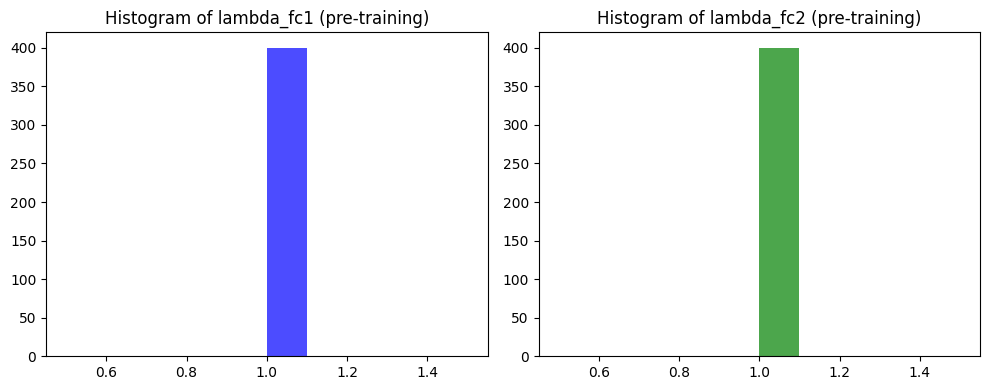

In [5]:
model = TwoHiddenLayerModel(hidden_dim1=400, hidden_dim2=300).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

lambda_fc1_orig = model.lambda_fc1.detach().cpu().numpy().copy()
lambda_fc2_orig = model.lambda_fc2.detach().cpu().numpy().copy()

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(abs(lambda_fc1_orig), bins=10, color='blue', alpha=0.7)
plt.title("Histogram of lambda_fc1 (pre-training)")

plt.subplot(1, 2, 2)
plt.hist(abs(lambda_fc1_orig), bins=10, color='green', alpha=0.7)
plt.title("Histogram of lambda_fc2 (pre-training)")

plt.tight_layout()
plt.show()


Original eigenvalues are Stored before pruning and histogram of their norm is plotted

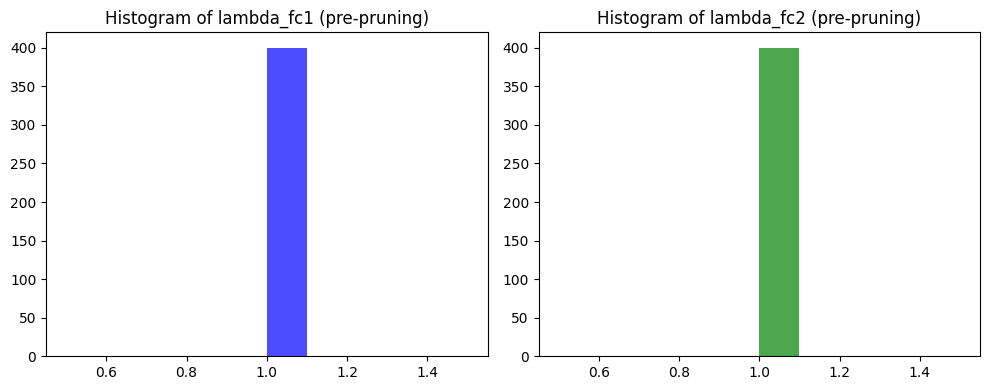

In [6]:
lambda_fc1_orig = model.lambda_fc1.detach().cpu().numpy().copy()
lambda_fc2_orig = model.lambda_fc2.detach().cpu().numpy().copy()

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(abs(lambda_fc1_orig), bins=10, color='blue', alpha=0.7)
plt.title("Histogram of lambda_fc1 (pre-pruning)")

plt.subplot(1, 2, 2)
plt.hist(abs(lambda_fc1_orig), bins=10, color='green', alpha=0.7)
plt.title("Histogram of lambda_fc2 (pre-pruning)")

plt.tight_layout()
plt.show()


In [7]:
# Arrays to store training and test metrics across calls
train_loss_history = []
test_accuracy_history = []
learned_parameters = {"lambda_fc1": [], "lambda_fc2": []}

In [8]:

def train_model_partial(
    model,
    train_loader,
    test_loader,
    loss_fn,
    optimizer,
    num_epochs,
    device,
    start_epoch=0,
):
    global train_loss_history, test_accuracy_history, learned_parameters

    for epoch in range(start_epoch, start_epoch + num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Calculate average loss for the epoch
        avg_loss = running_loss / len(train_loader)
        train_loss_history.append(avg_loss)

        # Evaluate the model on the test set
        test_accuracy = evaluate_accuracy(test_loader, model)
        test_accuracy_history.append(test_accuracy)

        # Save learned parameters
        with torch.no_grad():
            learned_parameters["lambda_fc1"].append(model.lambda_fc1.cpu().numpy().copy())
            learned_parameters["lambda_fc2"].append(model.lambda_fc2.cpu().numpy().copy())

        print(
            f"Epoch [{epoch + 1}] "
            f"Train Loss: {avg_loss:.4f} "
            f"Test Accuracy: {test_accuracy:.4f}"
        )


# Example usage
train_model_partial(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    num_epochs=10,
    device=device,
)

lambda_fc1_history = np.array(learned_parameters["lambda_fc1"])
lambda_fc2_history = np.array(learned_parameters["lambda_fc2"])


Epoch [1] Train Loss: 1.2903 Test Accuracy: 0.6859
Epoch [2] Train Loss: 0.8879 Test Accuracy: 0.7098
Epoch [3] Train Loss: 0.7779 Test Accuracy: 0.7402
Epoch [4] Train Loss: 0.7254 Test Accuracy: 0.7528
Epoch [5] Train Loss: 0.6914 Test Accuracy: 0.7692
Epoch [6] Train Loss: 0.6628 Test Accuracy: 0.7734
Epoch [7] Train Loss: 0.6506 Test Accuracy: 0.7852
Epoch [8] Train Loss: 0.6370 Test Accuracy: 0.7775
Epoch [9] Train Loss: 0.6393 Test Accuracy: 0.7842
Epoch [10] Train Loss: 0.6293 Test Accuracy: 0.7735


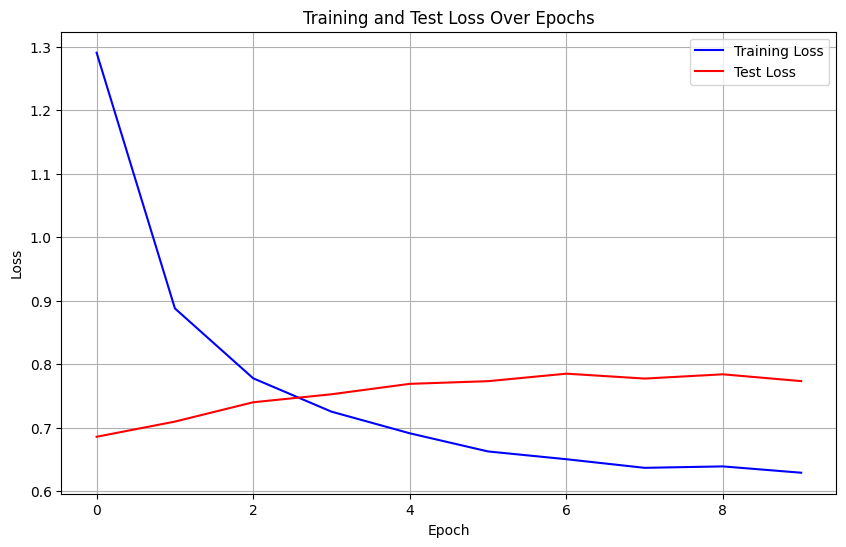

In [9]:
# Plot the training and test loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label="Training Loss", color="blue")
plt.plot(test_accuracy_history, label="Test Loss", color="red")
plt.title("Training and Test Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


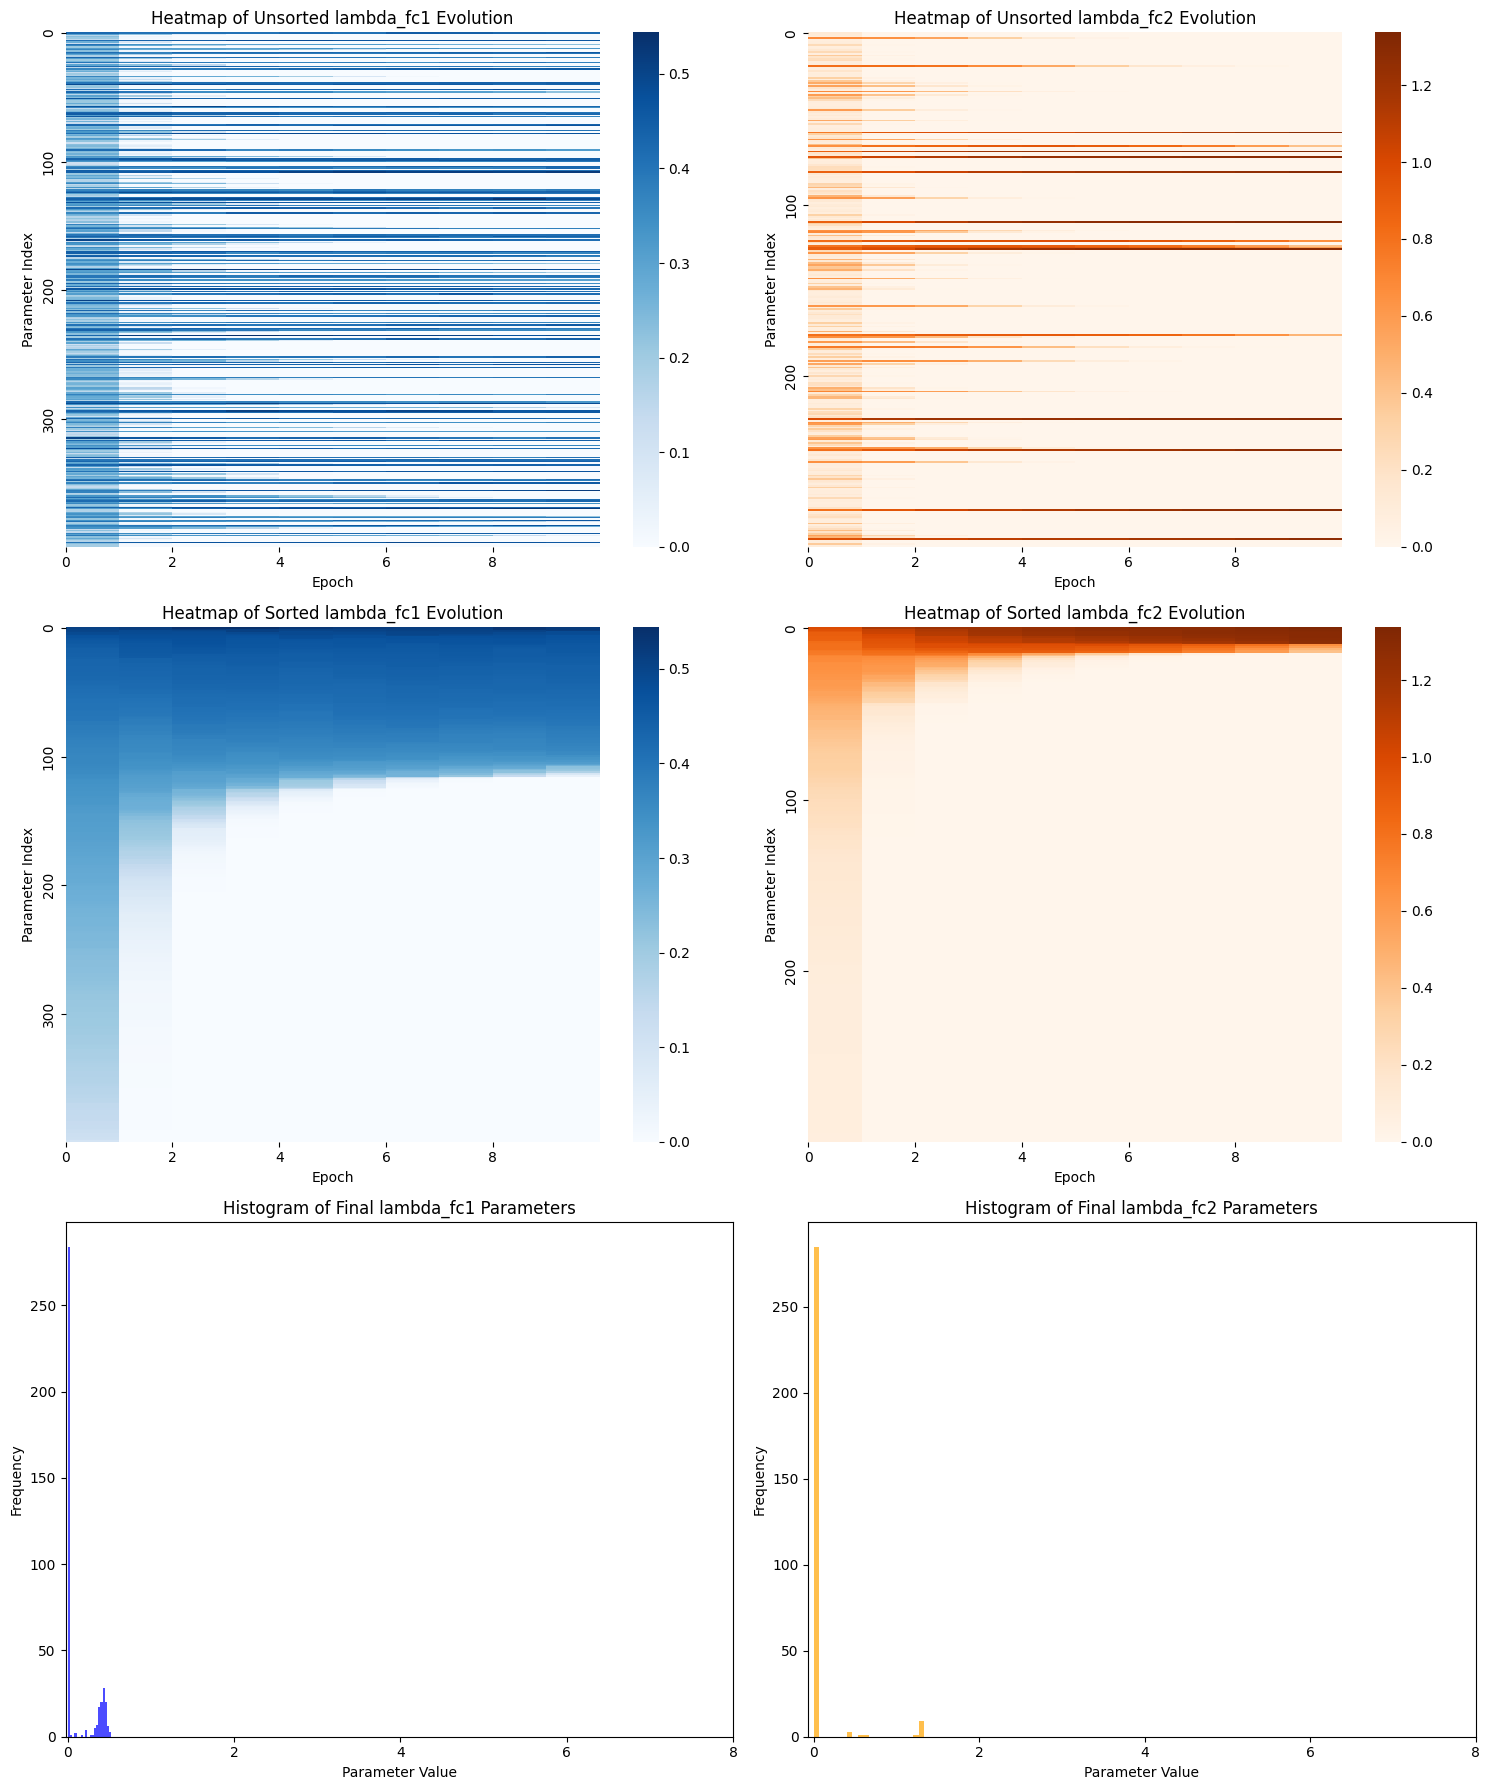

In [10]:
# Concatenate lambda_fc1 and lambda_fc2 into separate matrices for plotting
lambda_fc1_history = np.array(learned_parameters["lambda_fc1"])
lambda_fc2_history = np.array(learned_parameters["lambda_fc2"])

# Transpose the matrices so that epochs are on the x-axis and parameters are on the y-axis
lambda_fc1_history = lambda_fc1_history.T
lambda_fc2_history = lambda_fc2_history.T

# Sort each epoch (column) so the largest value is on top
lambda_fc1_sorted = np.sort(lambda_fc1_history, axis=0)[::-1]  # Sort each column in descending order
lambda_fc2_sorted = np.sort(lambda_fc2_history, axis=0)[::-1]

# Create y-axis labels for every 100th parameter index
yticks = np.arange(0, lambda_fc1_history.shape[0], 100)  # Indices every 100 parameters
yticklabels = [str(i) for i in yticks]  # Convert to string for labeling

# Create subplots: 3 rows, 2 columns (for heatmaps and histograms)
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

# Plot the first heatmap (unsorted lambda_fc1 evolution)
sns.heatmap(lambda_fc1_history, cmap="Blues", cbar=True, xticklabels=50, yticklabels=100, ax=axes[0, 0])
axes[0, 0].set_title("Heatmap of Unsorted lambda_fc1 Evolution")
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Parameter Index")
axes[0, 0].tick_params(axis='y', rotation=90)

# Plot the second heatmap (unsorted lambda_fc2 evolution)
sns.heatmap(lambda_fc2_history, cmap="Oranges", cbar=True, xticklabels=50, yticklabels=100, ax=axes[0, 1])
axes[0, 1].set_title("Heatmap of Unsorted lambda_fc2 Evolution")
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("Parameter Index")
axes[0, 1].tick_params(axis='y', rotation=90)

# Plot the first heatmap (sorted lambda_fc1 evolution)
sns.heatmap(lambda_fc1_sorted, cmap="Blues", cbar=True, xticklabels=50, yticklabels=100, ax=axes[1, 0])
axes[1, 0].set_title("Heatmap of Sorted lambda_fc1 Evolution")
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("Parameter Index")
axes[1, 0].tick_params(axis='y', rotation=90)

# Plot the second heatmap (sorted lambda_fc2 evolution)
sns.heatmap(lambda_fc2_sorted, cmap="Oranges", cbar=True, xticklabels=50, yticklabels=100, ax=axes[1, 1])
axes[1, 1].set_title("Heatmap of Sorted lambda_fc2 Evolution")
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].set_ylabel("Parameter Index")
axes[1, 1].tick_params(axis='y', rotation=90)

# Plot the first histogram (distribution of lambda_fc1 at the final epoch)
axes[2, 0].hist(lambda_fc1_history[:, -1], bins=20, color='blue', alpha=0.7)
axes[2, 0].set_title("Histogram of Final lambda_fc1 Parameters")
axes[2, 0].set_xlabel("Parameter Value")
axes[2, 0].set_ylabel("Frequency")

# Plot the second histogram (distribution of lambda_fc2 at the final epoch)
axes[2, 1].hist(lambda_fc2_history[:, -1], bins=20, color='orange', alpha=0.7)
axes[2, 1].set_title("Histogram of Final lambda_fc2 Parameters")
axes[2, 1].set_xlabel("Parameter Value")
axes[2, 1].set_ylabel("Frequency")

# Adjust x-axis ticks for all plots
for ax in axes.flatten():
    ax.set_xticks(np.arange(0, lambda_fc1_sorted.shape[1], lambda_fc1_sorted.shape[1] // 5))
    ax.set_xticklabels(np.arange(0, lambda_fc1_sorted.shape[1], lambda_fc1_sorted.shape[1] // 5))

# Adjust layout for better spacing
plt.tight_layout()
plt.show()



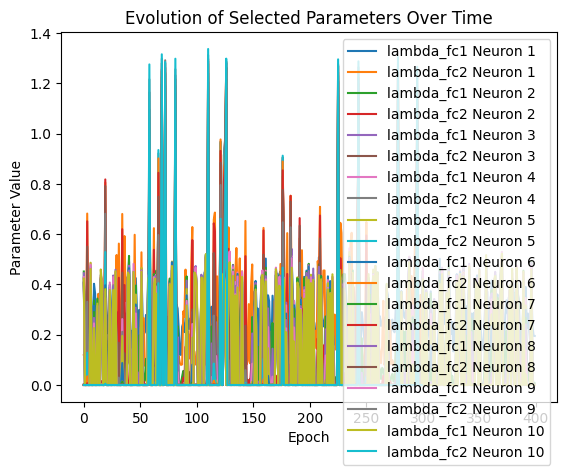

In [11]:
# Select a few parameters to visualize (e.g., the first 10 parameters of lambda_fc1)
for i in range(10):  # Plot the first 10 parameters as an example
    plt.plot(lambda_fc1_history[:, i], label=f"lambda_fc1 Neuron {i+1}")
    plt.plot(lambda_fc2_history[:, i], label=f"lambda_fc2 Neuron {i+1}")

plt.title("Evolution of Selected Parameters Over Time")
plt.xlabel("Epoch")
plt.ylabel("Parameter Value")
plt.legend()
plt.show()

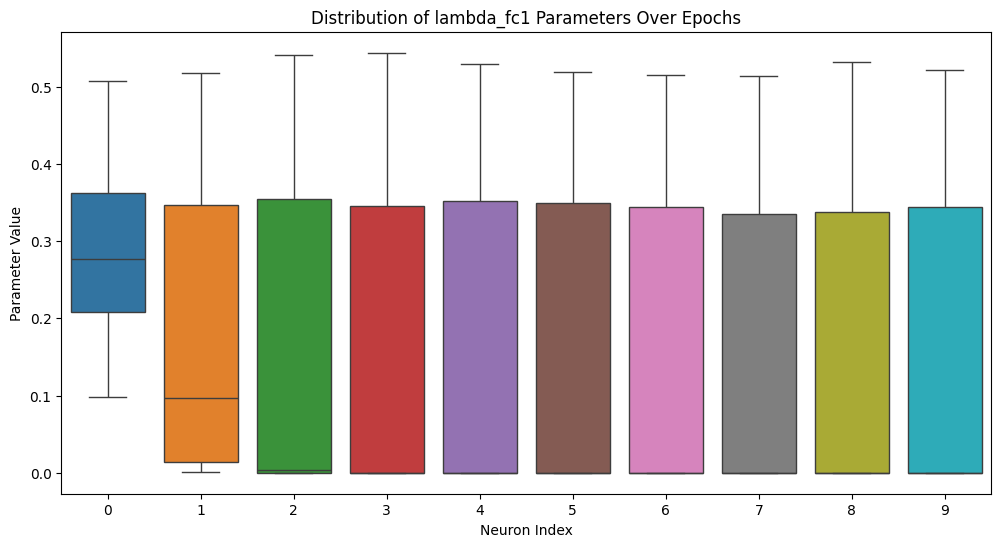

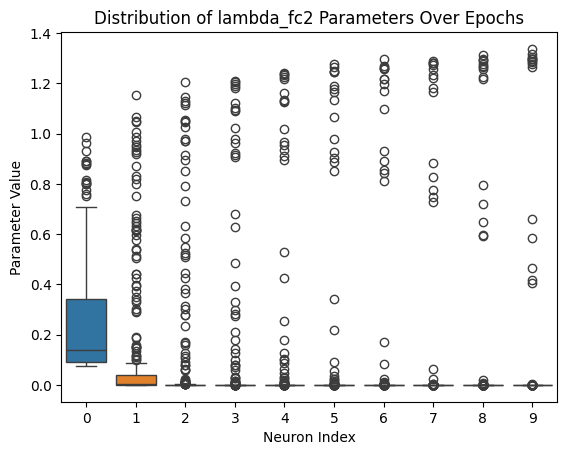

In [12]:
# Plot the distribution of parameters for each epoch using boxplots
plt.figure(figsize=(12, 6))

# Boxplot for lambda_fc1 (first 10 neurons as an example)
sns.boxplot(data=lambda_fc1_history[:, :10])
plt.title("Distribution of lambda_fc1 Parameters Over Epochs")
plt.xlabel("Neuron Index")
plt.ylabel("Parameter Value")
plt.show()

# Boxplot for lambda_fc2 (first 10 neurons as an example)
sns.boxplot(data=lambda_fc2_history[:, :10])
plt.title("Distribution of lambda_fc2 Parameters Over Epochs")
plt.xlabel("Neuron Index")
plt.ylabel("Parameter Value")
plt.show()


In [ ]:
def prune_model(model, percentile=50):
    # Step 1: Calculate the absolute values of lambda_fc1 and lambda_fc2
    lambda_fc1_abs = torch.abs(model.lambda_fc1).detach().cpu().numpy()
    lambda_fc2_abs = torch.abs(model.lambda_fc2).detach().cpu().numpy()

    # Step 2: Determine the pruning threshold using the given percentile
    threshold_fc1 = np.percentile(lambda_fc1_abs, percentile)
    threshold_fc2 = np.percentile(lambda_fc2_abs, percentile)

    # Step 3: Apply pruning (set values below the threshold to zero)
    mask_fc1 = lambda_fc1_abs >= threshold_fc1
    mask_fc2 = lambda_fc2_abs >= threshold_fc2

    # Prune the parameters by applying the binary mask
    model.lambda_fc1.data[~torch.tensor(mask_fc1)] = 0
    model.lambda_fc2.data[~torch.tensor(mask_fc2)] = 0

    # Step 4: Report the number of non-zero values remaining
    non_zero_fc1 = np.sum(mask_fc1)
    non_zero_fc2 = np.sum(mask_fc2)

    print(f"Non-zero values in lambda_fc1 after pruning: {non_zero_fc1}")
    print(f"Non-zero values in lambda_fc2 after pruning: {non_zero_fc2}")

    return lambda_fc1_abs, lambda_fc2_abs, non_zero_fc1, non_zero_fc2

# prune_model(model, percentile=75)

Non-zero values in lambda_fc1 after pruning: 100
Non-zero values in lambda_fc2 after pruning: 75


(array([4.23005134e-01, 3.24240354e-33, 1.35575626e-41, 2.80399823e-42,
        3.87038636e-42, 9.82029964e-42, 4.61519629e-01, 2.51492437e-40,
        3.50184486e-42, 2.26524010e-01, 1.41008407e-13, 4.58224598e-42,
        3.23953539e-01, 2.32117060e-07, 8.28167392e-43, 4.59746957e-01,
        4.04792994e-01, 4.99304140e-35, 8.38256741e-42, 3.81243199e-01,
        3.87630042e-28, 3.41916825e-42, 2.00105421e-42, 3.77984166e-01,
        2.47469309e-42, 4.12403415e-21, 3.77928793e-01, 1.15957448e-41,
        4.52759773e-01, 2.67928266e-42, 1.97302824e-42, 9.76004380e-42,
        1.49518546e-42, 1.20091278e-42, 6.08740208e-07, 4.44632003e-42,
        3.42698189e-39, 7.27273903e-42, 1.82139676e-32, 4.47847635e-01,
        4.38174427e-01, 5.14556796e-42, 1.32044354e-41, 1.38812626e-41,
        4.49775815e-01, 1.05966190e-41, 2.23220780e-01, 4.74391293e-35,
        1.40690366e-42, 9.20913796e-30, 6.38992100e-43, 4.50394988e-01,
        2.71011123e-42, 4.72798102e-42, 4.04975256e-43, 1.058745

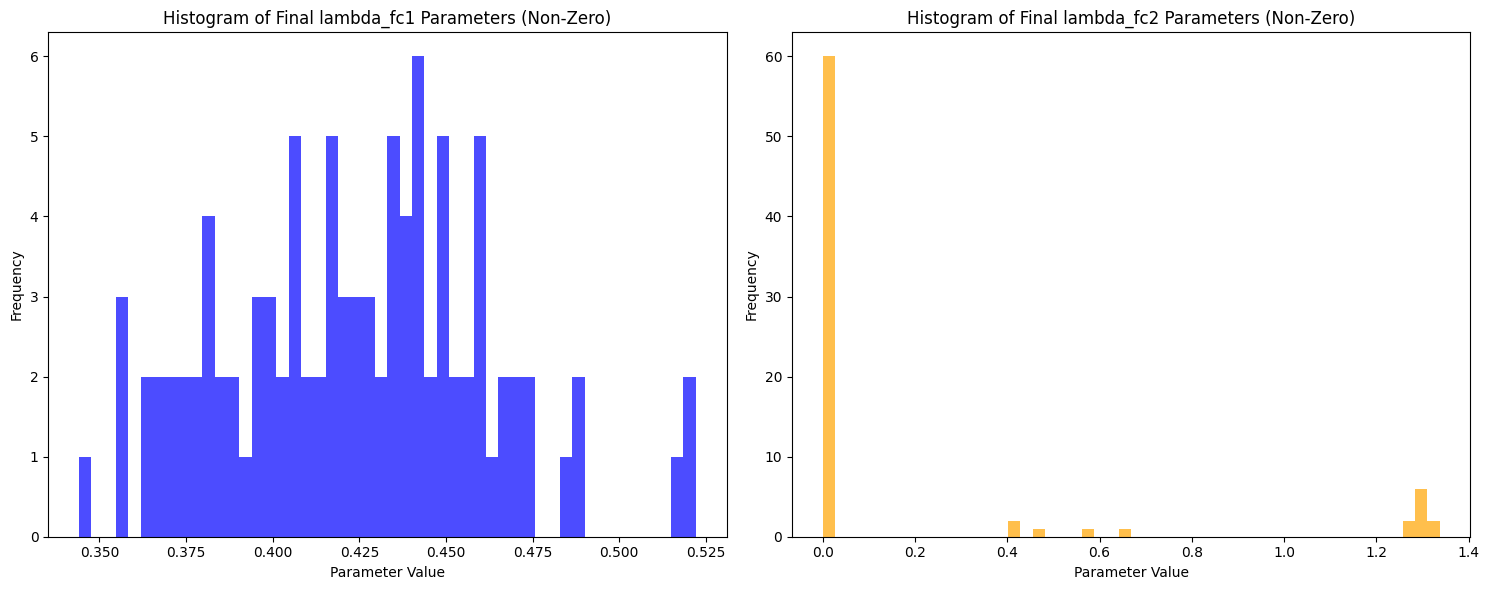

In [14]:
# Filter out zero values from both lambda_fc1 and lambda_fc2

lambda_fc1_pruned = model.lambda_fc1.detach().cpu().numpy().copy()
lambda_fc2_pruned = model.lambda_fc2.detach().cpu().numpy().copy()

lambda_fc1_nonzero = lambda_fc1_pruned[lambda_fc1_pruned != 0]
lambda_fc2_nonzero = lambda_fc2_pruned[lambda_fc2_pruned != 0]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the first histogram (distribution of lambda_fc1 at the final epoch, excluding zeros)
axes[0].hist(lambda_fc1_nonzero, bins=50, color='blue', alpha=0.7)
axes[0].set_title("Histogram of Final lambda_fc1 Parameters (Non-Zero)")
axes[0].set_xlabel("Parameter Value")
axes[0].set_ylabel("Frequency")

# Plot the second histogram (distribution of lambda_fc2 at the final epoch, excluding zeros)
axes[1].hist(lambda_fc2_nonzero, bins=50, color='orange', alpha=0.7)
axes[1].set_title("Histogram of Final lambda_fc2 Parameters (Non-Zero)")
axes[1].set_xlabel("Parameter Value")
axes[1].set_ylabel("Frequency")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()



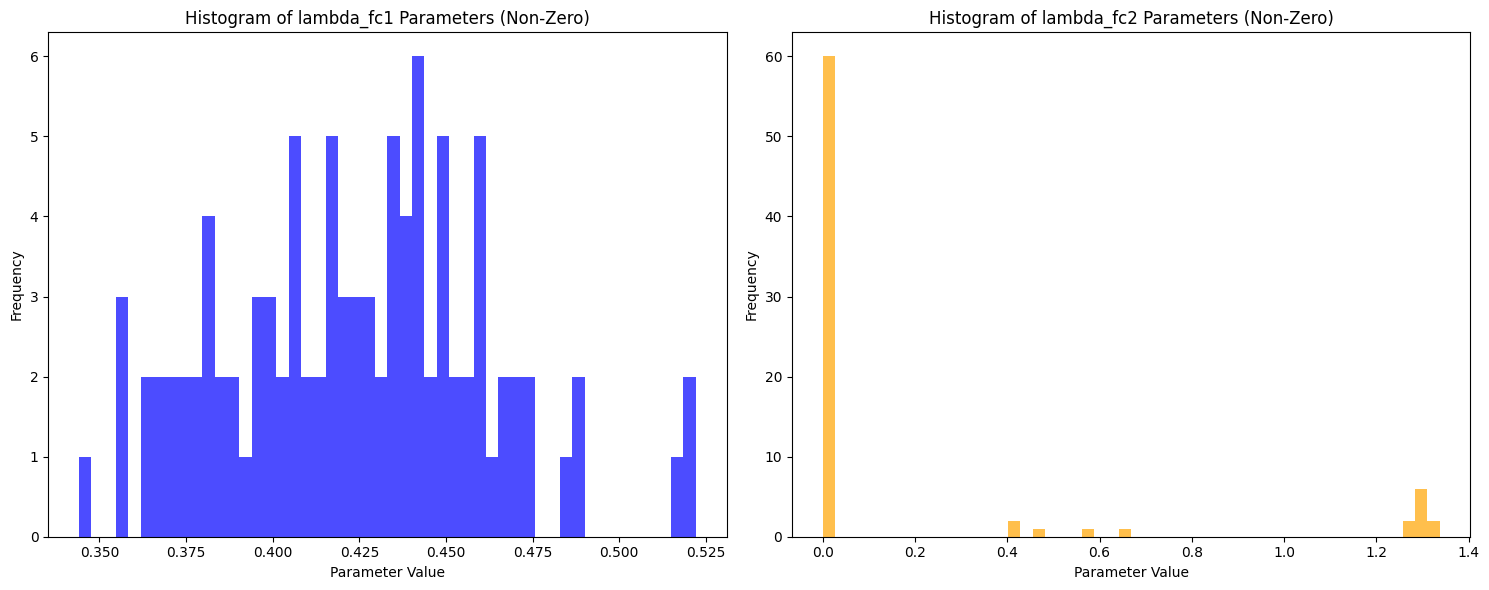

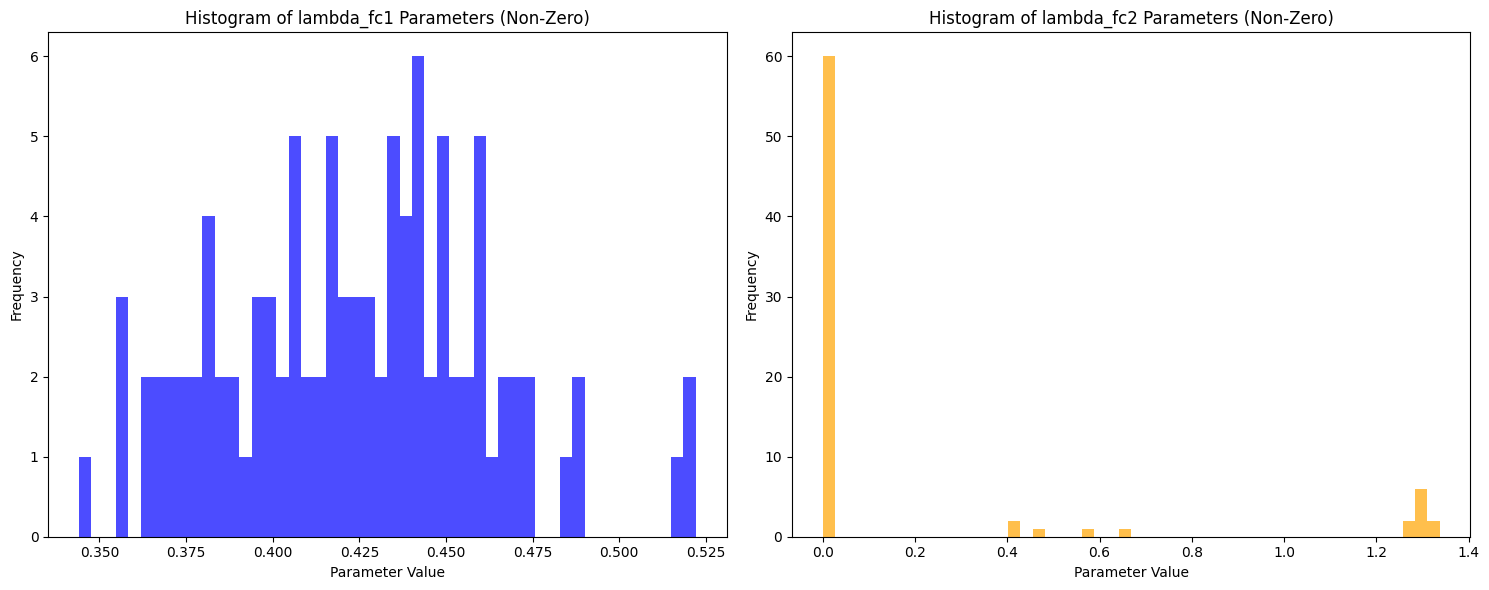

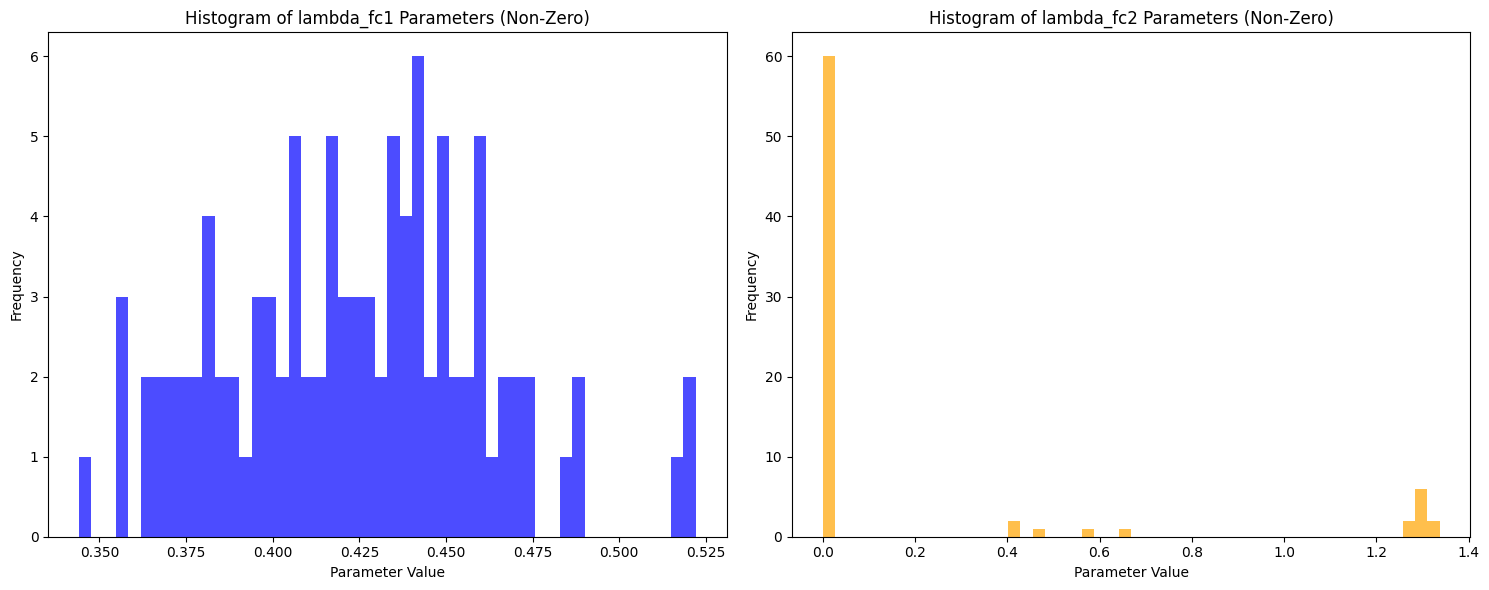

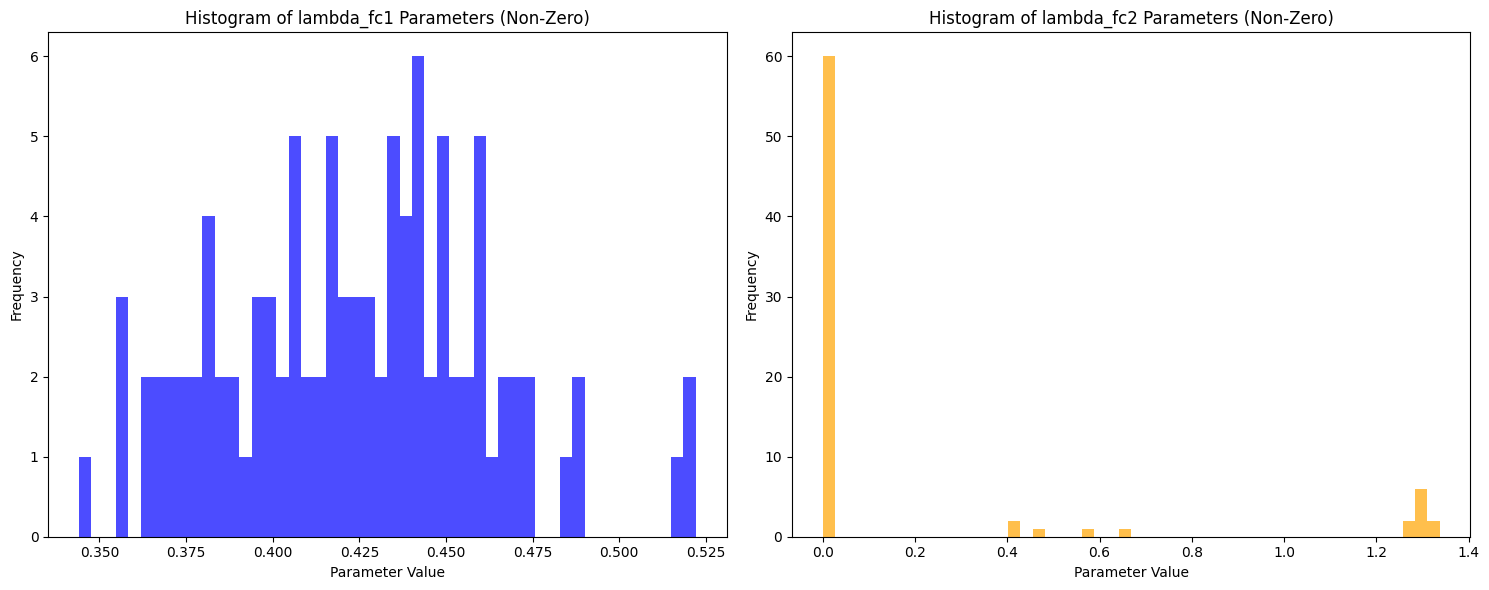

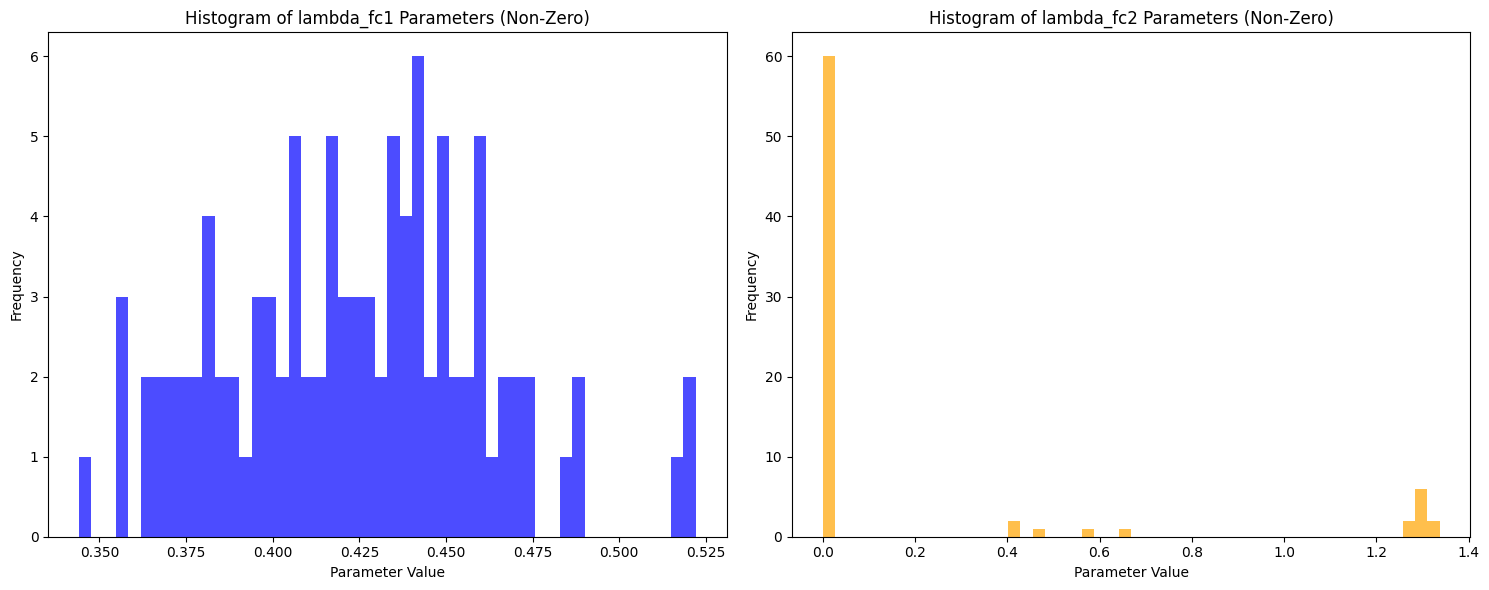

In [ ]:
def prune_and_evaluate_with_histograms(model, train_loader, test_loader, percentile):
    """
    Prune model parameters at the specified percentile, evaluate accuracy, and plot histograms.
    """
    # Calculate the pruning threshold for both lambda_fc1 and lambda_fc2
    lambda_fc1_abs = model.lambda_fc1.abs().cpu().detach().numpy()
    lambda_fc2_abs = model.lambda_fc2.abs().cpu().detach().numpy()
    
    # Determine the threshold using the given percentile
    threshold_fc1 = np.percentile(lambda_fc1_abs, percentile)
    threshold_fc2 = np.percentile(lambda_fc2_abs, percentile)
    
    # Apply the pruning: Set values below the threshold to zero
    mask_fc1 = lambda_fc1_abs >= threshold_fc1
    mask_fc2 = lambda_fc2_abs >= threshold_fc2
    
    # Apply the mask to the model parameters
    model.lambda_fc1.data[~torch.tensor(mask_fc1)] = 0
    model.lambda_fc2.data[~torch.tensor(mask_fc2)] = 0
    
    # Evaluate the accuracy on the test set after pruning
    accuracy = evaluate_accuracy(test_loader, model)
    
    # Plot histograms of lambda_fc1 and lambda_fc2 (non-zero values)
    plot_histograms(model)
    
    return accuracy

def evaluate_accuracy(dataloader, model):
    """
    Evaluate the model's accuracy on the given dataset.
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total

def plot_histograms(model):
    """
    Plot histograms of lambda_fc1 and lambda_fc2 parameters excluding zeros.
    """
    # Filter out zero values from both lambda_fc1 and lambda_fc2
    lambda_fc1_pruned = model.lambda_fc1.detach().cpu().numpy().copy()
    lambda_fc2_pruned = model.lambda_fc2.detach().cpu().numpy().copy()

    lambda_fc1_nonzero = lambda_fc1_pruned[lambda_fc1_pruned != 0]
    lambda_fc2_nonzero = lambda_fc2_pruned[lambda_fc2_pruned != 0]

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plot the first histogram (distribution of lambda_fc1 after pruning, excluding zeros)
    axes[0].hist(lambda_fc1_nonzero, bins=50, color='blue', alpha=0.7)
    axes[0].set_title("Histogram of lambda_fc1 Parameters (Non-Zero)")
    axes[0].set_xlabel("Parameter Value")
    axes[0].set_ylabel("Frequency")

    # Plot the second histogram (distribution of lambda_fc2 after pruning, excluding zeros)
    axes[1].hist(lambda_fc2_nonzero, bins=50, color='orange', alpha=0.7)
    axes[1].set_title("Histogram of lambda_fc2 Parameters (Non-Zero)")
    axes[1].set_xlabel("Parameter Value")
    axes[1].set_ylabel("Frequency")

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

# Define a range of percentiles to test
percentiles = np.arange(10, 91, 10)  # 10%, 20%, ..., 90%

# Store the accuracy results for each percentile
accuracy_results = []

# Now evaluate the accuracy and plot histograms after pruning at different percentiles
for percentile in percentiles:
    accuracy = prune_and_evaluate_with_histograms(model, train_loader, test_loader, percentile)
    accuracy_results.append(accuracy)

# Report the results
for percentile, accuracy in zip(percentiles, accuracy_results):
    print(f"Percentile: {percentile}% - Accuracy: {accuracy:.4f}")
